# PS1: Edges and Lines
---
## Setup

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.rcParams['figure.figsize'] = (12, 8.0)    
plt.rcParams['image.cmap'] = 'gray'

---
## 1. Find edges

In [4]:
img0 = cv.imread('ps1-input0.png')
# OpenCV BGR to RGB
img0 = img0[:,:,::-1]

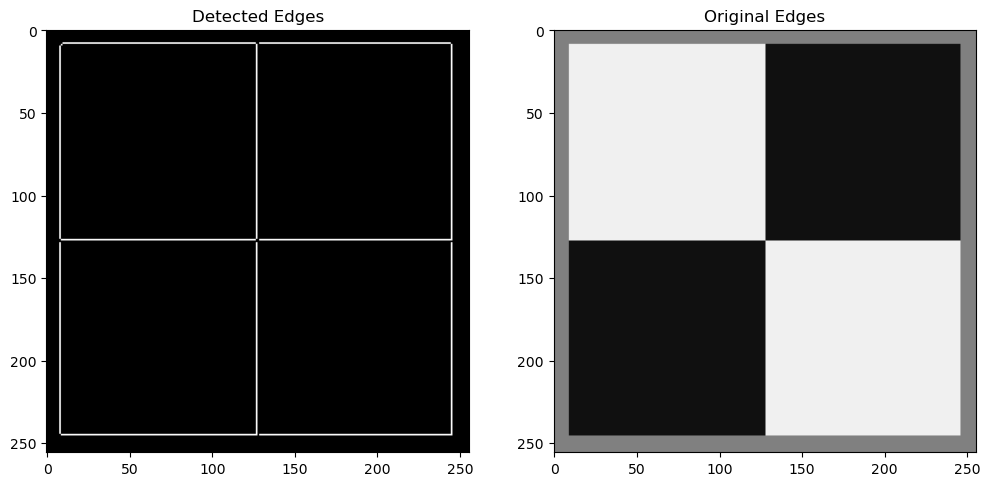

In [5]:
edge_img0 = cv.Canny(img0, 100, 200)
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Detected Edges')
ax[0].imshow(edge_img0)
ax[1].set_title('Original Edges')
ax[1].imshow(img0)

---
## 2. Hough Method for Finding Lines

In [6]:
def accumulate(img, rho_res=1.0, theta_res=np.pi/180): 
    rho_max = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    rho_min = -rho_max
    # Ranges
    num_rho = int(round((rho_max-rho_min) / rho_res)) + 1    
    thetas = np.arange(0, np.pi, theta_res)                            
    acc = np.zeros((num_rho, thetas.size))                          
    # voting
    ys, xs = img.nonzero()                                            
    rhos = np.outer(xs, np.cos(thetas)) + np.outer(ys, np.sin(thetas))
    
    rho_ixs = np.round((rhos - rho_min) / rho_res).astype(int)
    theta_ixs = np.arange(thetas.size)                                      
    for rho_ix_point in rho_ixs:
        acc[rho_ix_point, theta_ixs] += 1                            
    return acc

def extract_lines(img, acc, rho_res=1.0, theta_res=np.pi/180, thresh=100): 
    # Take only local maximas > threshold
    rho_max = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
    rho_min = -rho_max
    lines = []         # peaks
    num_rho, num_theta = acc.shape
    indices = np.argwhere(acc > thresh) # only use the points that higher than thresh
    for rho_ix, theta_ix in indices:
        if rho_ix == 0 or rho_ix == num_rho-1:
            continue
        rho = rho_min + rho_res * rho_ix    # each rho
        theta = theta_res * theta_ix             # each theta
        # consider the edge of acc
        if theta_ix == 0:   # left
            rho_left = int(round((-rho-rho_min) / rho_res))
            left = acc[rho_left, -1]
            right = acc[rho_ix, theta_ix+1]  # no change to right
        elif theta_ix == num_theta-1:   # right
            rho_right = int(round((-rho-rho_min) / rho_res))
            left = acc[rho_ix, theta_ix-1]   # no change to left
            right = acc[rho_right, 0]    
        # Normal point
        else:
            left = acc[rho_ix, theta_ix-1]
            right = acc[rho_ix, theta_ix+1]

        # Check if local maxima   
        if acc[rho_ix, theta_ix] > acc[rho_ix-1, theta_ix] and \
        acc[rho_ix, theta_ix] >= acc[rho_ix+1, theta_ix] and \
        acc[rho_ix, theta_ix] > left and acc[rho_ix, theta_ix] >= right:
            lines.append((rho, theta))
    return lines


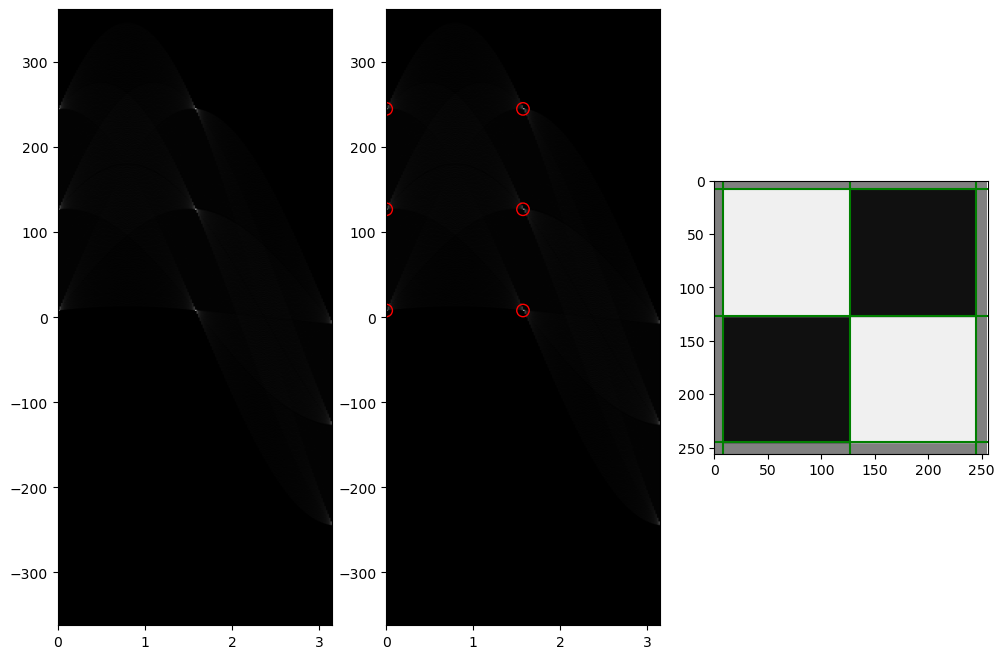

In [7]:
fig, ax = plt.subplots(1, 3)
rho_max = np.sqrt(edge_img0.shape[0]**2 + edge_img0.shape[1]**2)
rho_min = -rho_max
# 1. accum 

hough_acc_img0 = accumulate(edge_img0)
ax[0].set_ylim(rho_min, rho_max)
ax[0].set_xlim(0, np.pi)
ax[0].imshow(hough_acc_img0, aspect='auto', origin='lower', extent=[0, np.pi, rho_min, rho_max])


# 2. accum peaks
ax[1].imshow(hough_acc_img0, aspect='auto', origin='lower', extent=[0, np.pi, rho_min, rho_max])
detected_lines = extract_lines(edge_img0, hough_acc_img0)  # detected peaks
for rho, theta in detected_lines:
    ax[1].scatter(theta, rho, s=80, facecolors='none', edgecolors='r')

# 3. draw lines
plot_range = range(256)
ax[2].set_ylim(img0.shape[0], 0)
ax[2].set_xlim(0, img0.shape[1])
ax[2].imshow(img0)
for rho, theta in detected_lines:
    # transfer (rho, theta) to the lines   
    if np.sin(theta):
        fx = (rho - plot_range*np.cos(theta)) / np.sin(theta)
        ax[2].plot(fx, plot_range, 'g')
    else:
        # Vertical line
        fy = (rho - plot_range*np.sin(theta)) / np.cos(theta)
        ax[2].plot(plot_range, fy, 'g')

### how I choose the accumulater bin sizes:

The lines in this image is neat and there's no disturbtion for them, so small rho_res and theta_res are good for bin size. Then I adjust the threshold to find the peaks.

The parameters are as follows:<br>
Canny thresholds: 100, 200<br>
Hough accumulator sizes: theta is [0, pi] and rho is [-max_dig, max_diag], where max_dig represents the len of diagonal line<br>
Hough peaks method: threshold = 100 <br>
I set the step length to be rho_res=1.0, theta_res=pi/180<br>
The bin sized above makes my hough method show good result.


---
## 3. Edge Detection with Noise

In [8]:
img0_noise = cv.imread('ps1-input0-noise.png')
img0_noise = img0_noise[:,:,::-1]

### a. Use Gaussian Filter to smooth the picture

Text(0.5, 1.0, 'Original Image')

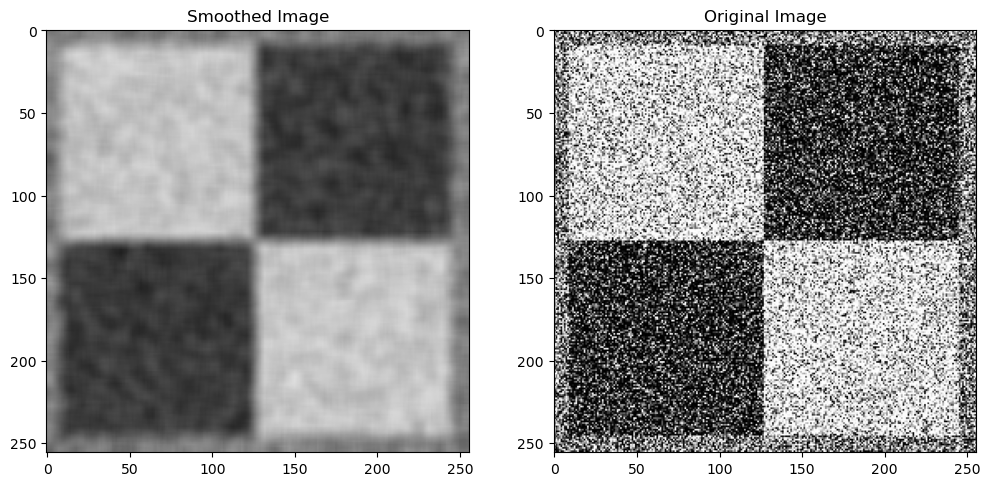

In [9]:
img0_noise_smooth = cv.GaussianBlur(img0_noise, (11, 11), 4)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img0_noise_smooth)
ax[0].set_title('Smoothed Image')
ax[1].imshow(img0_noise)
ax[1].set_title('Original Image')

### b. Edge Operator

Text(0.5, 1.0, 'Edges: Original Image')

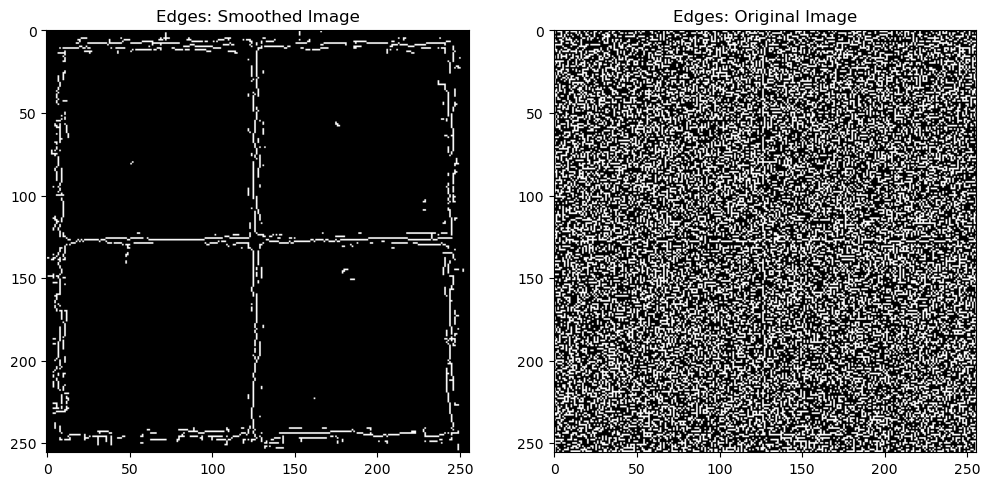

In [10]:
# Edge detection on original image and blurred image
img0_noise_edges = cv.Canny(img0_noise, 65, 70)
img0_noise_edges_smooth = cv.Canny(img0_noise_smooth, 65, 70)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img0_noise_edges_smooth)
ax[0].set_title('Edges: Smoothed Image')
ax[1].imshow(img0_noise_edges)
ax[1].set_title('Edges: Original Image')


### c. Hough Line detection

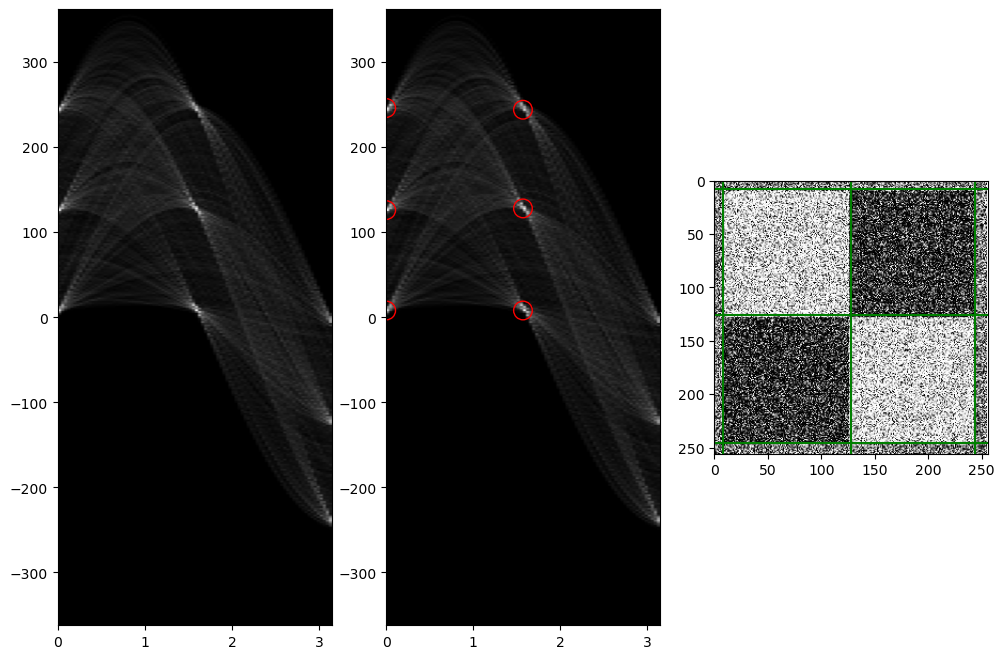

In [12]:
fig, ax = plt.subplots(1, 3)
rho_max = np.sqrt(img0_noise_edges_smooth.shape[0]**2 + img0_noise_edges_smooth.shape[1]**2)
rho_min = -rho_max

# parameters:
smooth_rho_res=2.0
smooth_theta_res=2.0 * np.pi / 180
smooth_thresh=120

# 1. accum 
hough_acc_img0_noise = accumulate(img0_noise_edges_smooth, rho_res=smooth_rho_res, 
                               theta_res=smooth_theta_res)
ax[0].set_ylim(rho_min, rho_max)
ax[0].set_xlim(0, np.pi)
ax[0].imshow(hough_acc_img0_noise, aspect='auto', origin='lower', extent=[0, np.pi, rho_min, rho_max])


# 2. accum peaks
ax[1].imshow(hough_acc_img0_noise, aspect='auto', origin='lower', extent=[0, np.pi, rho_min, rho_max])
detected_lines = extract_lines(img0_noise_edges_smooth, hough_acc_img0_noise, rho_res=smooth_rho_res, 
                               theta_res=smooth_theta_res, thresh=smooth_thresh)  # detected peaks
for rho, theta in detected_lines:
    ax[1].scatter(theta, rho, s=180, facecolors='none', edgecolors='r')

# 3. draw lines
plot_range = range(256)
ax[2].set_ylim(img0_noise.shape[0], 0)
ax[2].set_xlim(0, img0_noise.shape[1])
ax[2].imshow(img0_noise)
for rho, theta in detected_lines:
    # transfer (rho, theta) to the lines   
    if np.sin(theta):
        fx = (rho - plot_range*np.cos(theta)) / np.sin(theta)
        ax[2].plot(fx, plot_range, 'g')
    else:
        # Vertical line
        fy = (rho - plot_range*np.sin(theta)) / np.cos(theta)
        ax[2].plot(plot_range, fy, 'g')

Because of the noise, the edge image has some disturbance, as we can see from from the "Edges: Smoothed Image". So I adjust the bin size to be bigger to deal with the influence of the noise. Then I adjust the threshold to find the peaks. 

The parameters are as follows:<br>
Gaussian filter: kenerl size is 11 * 11, sigma is 4.<br>
Canny thresholds: 65, 70<br>
Hough accumulator sizes: theta is [0, pi] and rho is [-max_dig, max_diag]<br>
Hough peaks method: threshold = 120 <br>
I set the step length to be rho_res=2.0, theta_res=2 * pi/180 for hough line detection<br>
The bin sized above makes my hough method show good result.


---
## 4. Edge Detection for Another Image

In [13]:
img1 = cv.imread('ps1-input1.jpg')
img1 = img1[:,:,::-1]

### a. Use A Gaussian Filter to Smooth the Picture

Text(0.5, 1.0, 'Original Image')

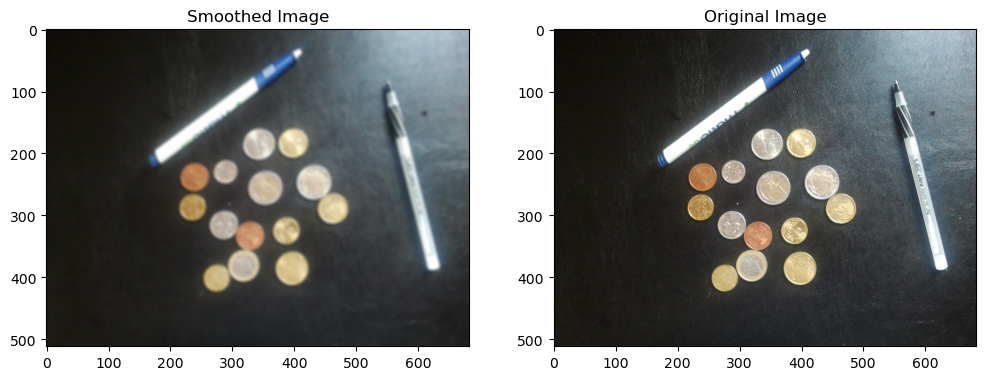

In [14]:
img1_smooth = cv.GaussianBlur(img1, (7, 7), 3)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1_smooth)
ax[0].set_title('Smoothed Image')
ax[1].imshow(img1)
ax[1].set_title('Original Image')

### b. Edge Operator

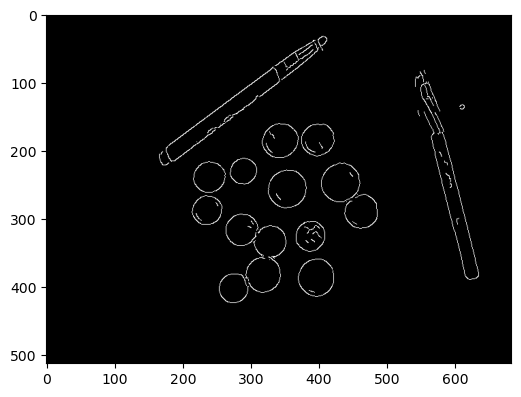

In [15]:
# Edge detection on blurred image
img1_edges_smooth = cv.Canny(img1_smooth, 80, 100)
# Plot
plt.figure(figsize=(6, 5))
plt.imshow(img1_edges_smooth)


### c. Hough Line detection for Pens

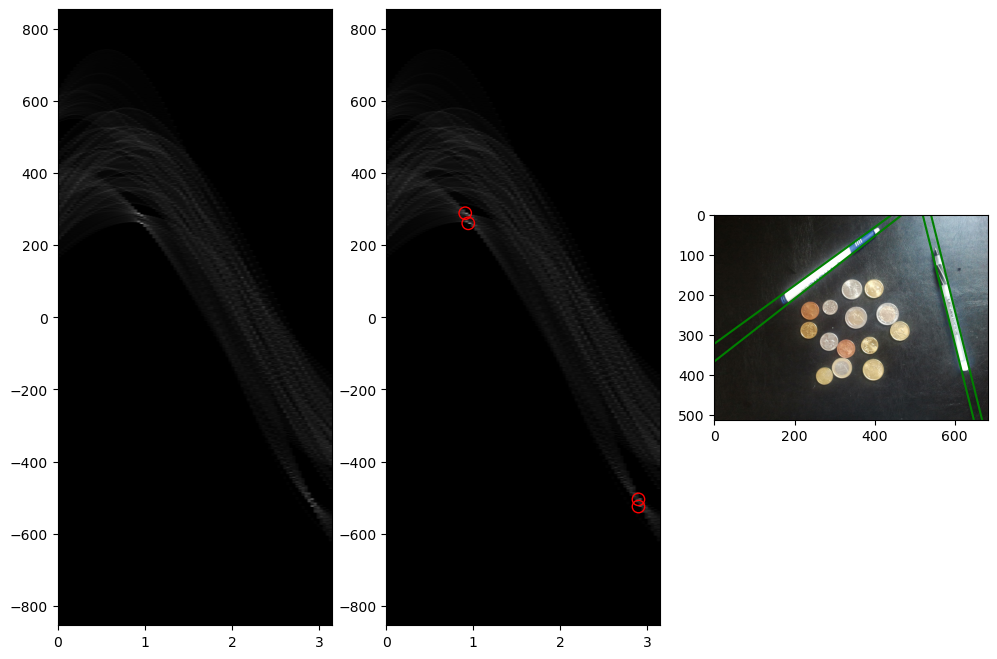

In [17]:
fig, ax = plt.subplots(1, 3)
rho_max = np.sqrt(img1_edges_smooth.shape[0]**2 + img1_edges_smooth.shape[1]**2)
rho_min = -rho_max

# parameters:
pen_rho_res=1.0
pen_theta_res=2.0 * np.pi / 180
pen_thresh=100

# 1. accum 
hough_acc_img1 = accumulate(img1_edges_smooth, rho_res = pen_rho_res, theta_res = pen_theta_res)
ax[0].set_ylim(rho_min, rho_max)
ax[0].set_xlim(0, np.pi)
ax[0].imshow(hough_acc_img1, aspect='auto', origin='lower', extent=[0, np.pi, rho_min, rho_max])


# 2. accum peaks
ax[1].imshow(hough_acc_img1, aspect='auto', origin='lower', extent=[0, np.pi, rho_min, rho_max])
detected_lines = extract_lines(img1_edges_smooth, hough_acc_img1, 
                               rho_res = pen_rho_res, theta_res = pen_theta_res, thresh = pen_thresh)  # detected peaks
for rho, theta in detected_lines:
    ax[1].scatter(theta, rho, s=80, facecolors='none', edgecolors='r')

# 3. draw lines
x_range = range(img1.shape[1])
y_range = range(img1.shape[0])
ax[2].set_ylim(img1.shape[0], 0)
ax[2].set_xlim(0, img1.shape[1])
ax[2].imshow(img1)
for rho, theta in detected_lines:
    # transfer (rho, theta) to the lines   
    if np.sin(theta):
        fx = (rho - x_range*np.cos(theta)) / np.sin(theta)
        ax[2].plot(x_range, fx,  'g')
    else:
        # Vertical line
        fy = (rho - y_range*np.sin(theta)) / np.cos(theta)
        ax[2].plot(y_range, fy, 'g')

What showed in "img1_edges_smooth" is that there are some small broken lines around lines, thus, I make the parameter "theta_res" bigger to avoid repeatly detection for a same line.

The parameters are as follows:<br>
Gaussian filter: kenerl size is 7 * 7, sigma is 3.<br>
Canny thresholds: 80, 100<br>
Hough accumulator sizes: theta is [0, pi] and rho is [-max_dig, max_diag]<br>
Hough peaks method: threshold = 100 <br>
I set the step length to be rho_res=1.0, theta_res=2 * pi/180 for hough line detection<br>
The bin sized above makes my hough method show good result.


---
## 5. Hough Detection for Circles

In [45]:
def accumulate_circle(image, r_min, r_max, r_res, ab_res):
    #limit a and b
    a_min = -r_max
    a_max = image.shape[1] + r_max
    b_min = -r_max
    b_max = image.shape[0] + r_max
    #creat the ranges and dimentions
    thetas = np.arange(0, 2 * np.pi, np.pi / 180)
    rs = np.arange(r_min, r_max, r_res)
    r_ixs = np.arange(rs.size)
    
    num_a = round((a_max - a_min) / ab_res)
    num_b = round((b_max - b_min) / ab_res)

    acc = np.zeros((num_b, num_a, rs.size))
    ys, xs = image.nonzero()
    for y, x in zip(ys, xs):
        x_center = x + np.outer(np.cos(thetas), rs)
        y_center = y + np.outer(np.sin(thetas), rs)
        
        x_ixs = np.round((x_center - a_min) / ab_res).astype(int)
        y_ixs = np.round((y_center - b_min) / ab_res).astype(int)
        acc[y_ixs, x_ixs, r_ixs] +=1
    return acc

def extract_circle(image, accum, r_min, r_max, r_res, ab_res, threshold):
    circles = []
    num_b, num_a, num_r = accum.shape
    a_min = -r_max
    a_max = image.shape[1] + r_max
    b_min = -r_max
    b_max = image.shape[0] + r_max
    indices = np.argwhere(accum > threshold)
    # print(indices)
    for y_ix, x_ix, r_ix in indices:
        if y_ix == 0 or y_ix == num_b-1 or x_ix == 0 or x_ix == num_a-1 or r_ix == 0 or r_ix == num_r-1:
            continue
        if accum[y_ix, x_ix, r_ix] > accum[y_ix-1, x_ix, r_ix] and \
        accum[y_ix, x_ix, r_ix] >= accum[y_ix+1, x_ix, r_ix] and \
        accum[y_ix, x_ix, r_ix] > accum[y_ix, x_ix-1, r_ix] and \
        accum[y_ix, x_ix, r_ix] >= accum[y_ix, x_ix+1, r_ix] and \
        accum[y_ix, x_ix, r_ix] > accum[y_ix, x_ix, r_ix-1] and \
        accum[y_ix, x_ix, r_ix] >= accum[y_ix, x_ix, r_ix+1]:
            a = x_ix * ab_res + a_min
            b = y_ix * ab_res + b_min
            r = r_ix * r_res + r_min
            circles.append((a, b, r))
    #filter the circles that are too close
    out_circles = []
    flagged = [False] * len(circles)
    for i1, (a1, b1, r1) in enumerate(circles):
        #check whether there are other similar circles
        for i2, (a2, b2, r2) in enumerate(circles[i1+1:]):
            if not flagged [i1 + i2 +1]:
                if np.sqrt((a2-a1)**2 + (b2-b1)**2) < 10 and abs(r2-r1) < 10:
                    # Circle 1
                    a1_ix = int(round((a1- a_min) / ab_res))
                    b1_ix = int(round((b1- b_min) / ab_res))
                    r1_ix = int(round((r1- r_min) / r_res))
                    # Circle 2
                    a2_ix = int(round((a2- a_min) / ab_res))
                    b2_ix = int(round((b2- b_min) / ab_res))
                    r2_ix = int(round((r2- r_min) / r_res))
                    if accum[b1_ix, a1_ix, r1_ix] > accum[b2_ix, a2_ix, r2_ix]: # abandon the smaller one
                        flagged[i1+i2+1] = True 
                    else:
                        flagged[i1] = True 
                        break
        if not flagged[i1]:
            out_circles.append((a1, b1, r1))
    return out_circles    

[(398.0, 184.0, 23.0), (344.0, 185.0, 25.0), (290.0, 230.0, 19.0), (240.0, 239.0, 23.0), (431.0, 248.0, 27.0), (353.0, 257.0, 27.0), (236.0, 288.0, 21.0), (462.0, 289.0, 25.0), (287.0, 316.0, 23.0), (388.0, 325.0, 21.0), (329.0, 333.0, 23.0), (319.0, 382.0, 25.0), (397.0, 386.0, 27.0), (275.0, 402.0, 21.0)]


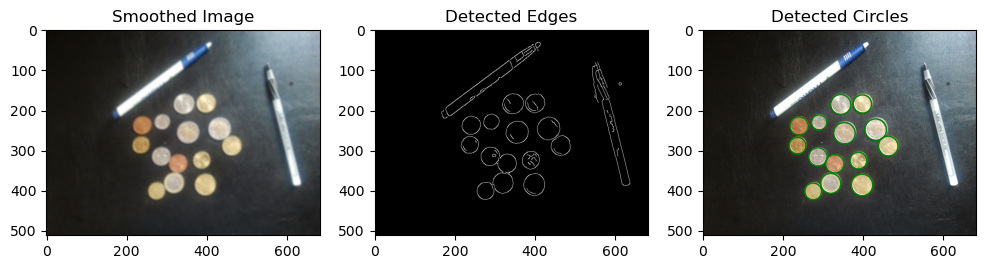

In [39]:
#smooth and edge detection
img1_smooth_circles = cv.GaussianBlur(img1, (7, 7), 3)
img1_smooth_circles_edges = cv.Canny(img1_smooth_circles, 50, 100)

r_min = 1.0
r_max = 300.0


circle_r_res = 2
circle_ab_res = 1
circle_threshold = 80


fig, ax = plt.subplots(1, 3)
# ax[0].set_ylim(b_min, b_max)
# ax[0].set_xlim(a_min, a_max)
ax[0].imshow(img1_smooth_circles)
ax[0].set_title('Smoothed Image')

# ax[1].set_ylim(b_min, b_max)
# ax[1].set_xlim(a_min, a_max)
ax[1].imshow(img1_smooth_circles_edges)
ax[1].set_title('Detected Edges')

image1_circles_acc = accumulate_circle(img1_smooth_circles_edges, r_min, r_max, r_res=circle_r_res, ab_res=circle_ab_res)
image1_circles = extract_circle(img1_smooth_circles_edges, image1_circles_acc, r_min, r_max, 2, 1, threshold = circle_threshold)

# ax[2].set_ylim(b_min, b_max)
# ax[2].set_xlim(a_min, a_max)
ax[2].set_title('Detected Circles')
ax[2].imshow(img1)
print(image1_circles)
for x,y,r in image1_circles:
    circ = plt.Circle((x, y), r,color = 'g', fill = False)
    ax[2].add_patch(circ)



The circle detection method is similar to the line detection method. For each pixel in circle edge, there will be many circles that can pass through it, with different center coordinates and radii. However, the pixels in the same circle would vote for a certain circle, which is the one that passes through these all pixels.
Therefore, the circle detection consists of two steps.Firstly, I creat the accumlate matrix for all the potential circles and conduct voting. Then I need to pick out the peaks that represent the center coodinates and radiis of these most possible circles.

The parameters are as follows:<br>
Gaussian filter: kenerl size is 7 * 7, sigma is 3.<br>
Canny thresholds: 50, 100<br>
Hough accumulator sizes: r_min = 1.0, r_max = 300.0<br>
Hough peaks method: threshold = 80<br>
I set the step length to be r_res=2.0, ab_res=1.0 for hough circle detection<br>
The bin sized above makes my hough method show good result.<br>




---
## 6. Clutter Image

In [20]:
img2 = cv.imread('ps1-input2.jpg')
img2 = img2[:,:,::-1]

### a. Line Detection

Text(0.5, 1.0, 'Original Image')

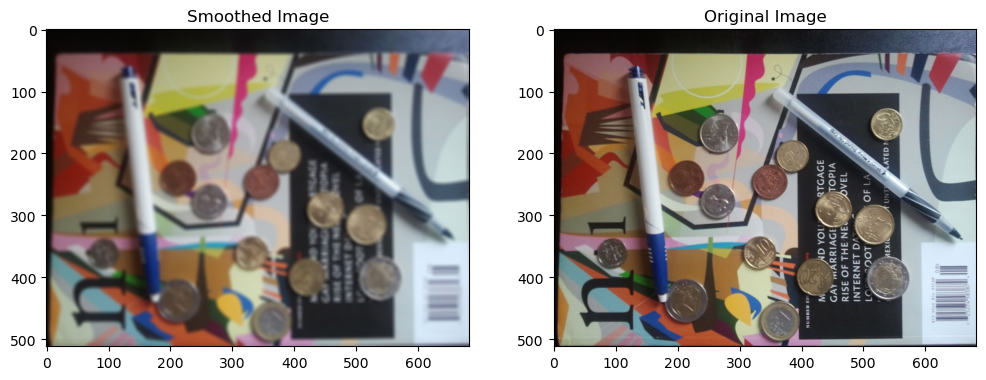

In [21]:
# Smoothing
img2_smooth = cv.GaussianBlur(img2, (9, 9), 3)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img2_smooth)
ax[0].set_title('Smoothed Image')
ax[1].imshow(img2)
ax[1].set_title('Original Image')

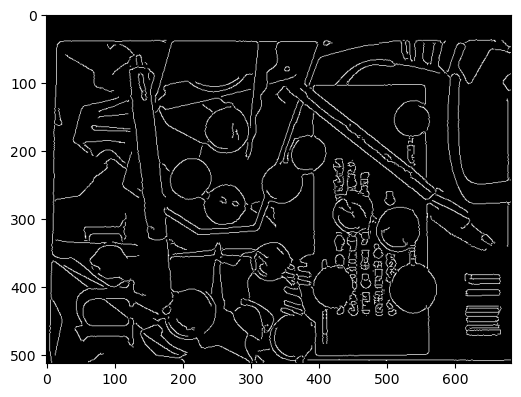

In [22]:
# Edge detection on blurred image
img2_edges_smooth = cv.Canny(img2_smooth, 10, 90)
# Plot
plt.figure(figsize=(6, 5))
plt.imshow(img2_edges_smooth)


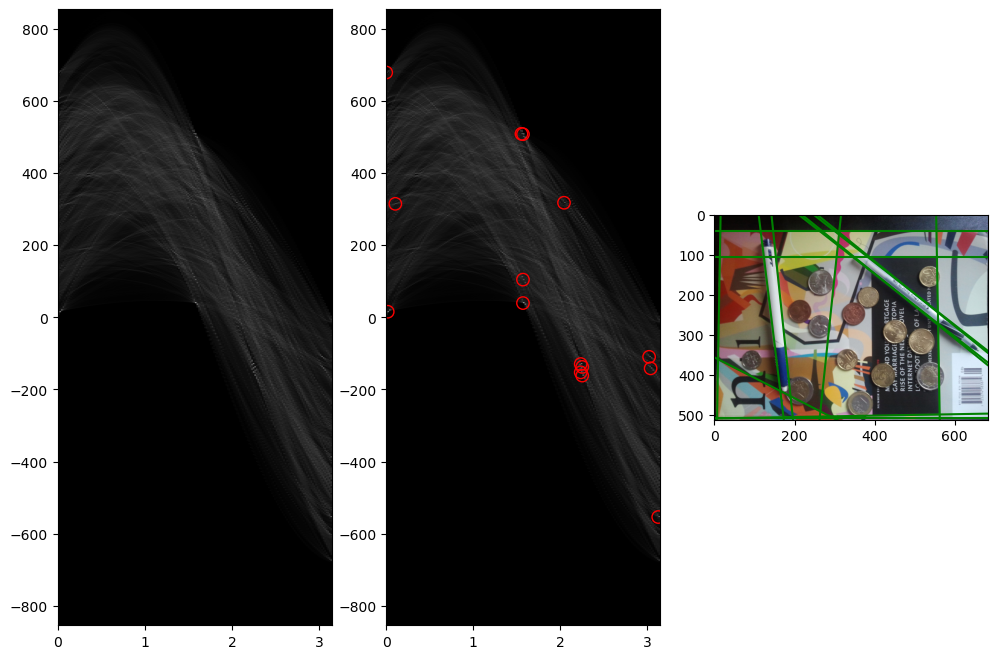

In [23]:
# Use hough line accumulator
fig, ax = plt.subplots(1, 3)
rho_max = np.sqrt(img2_edges_smooth.shape[0]**2 + img2_edges_smooth.shape[1]**2)
rho_min = -rho_max

# 1. accum 
hough_acc_img2 = accumulate(img2_edges_smooth, rho_res = 1.0, theta_res = 1.0 * np.pi/180)
ax[0].set_ylim(rho_min, rho_max)
ax[0].set_xlim(0, np.pi)
ax[0].imshow(hough_acc_img2, aspect='auto', origin='lower', extent=[0, np.pi, rho_min, rho_max])


# 2. accum peaks
ax[1].imshow(hough_acc_img2, aspect='auto', origin='lower', extent=[0, np.pi, rho_min, rho_max])
detected_lines = extract_lines(img2_edges_smooth, hough_acc_img2, rho_res = 1.0, theta_res =1.0 * np.pi/180, thresh = 130)  # detected peaks
for rho, theta in detected_lines:
    ax[1].scatter(theta, rho, s=80, facecolors='none', edgecolors='r')

# 3. draw lines
x_range = range(img2.shape[1])
y_range = range(img2.shape[0])
ax[2].set_ylim(img2.shape[0], 0)
ax[2].set_xlim(0, img2.shape[1])
ax[2].imshow(img2)
for rho, theta in detected_lines:
    # transfer (rho, theta) to the lines   
    if np.sin(theta):
        fx = (rho - x_range*np.cos(theta)) / np.sin(theta)
        ax[2].plot(x_range, fx,  'g')
    else:
        # Vertical line
        fy = (rho - y_range*np.sin(theta)) / np.cos(theta)
        ax[2].plot(y_range, fy, 'g')

### b. Problems
the detected lines consist of some lines that don't belong to pens. it is because the background of the image_2 includes some lines already.

### c. Finding nearby parallel lines for the pen

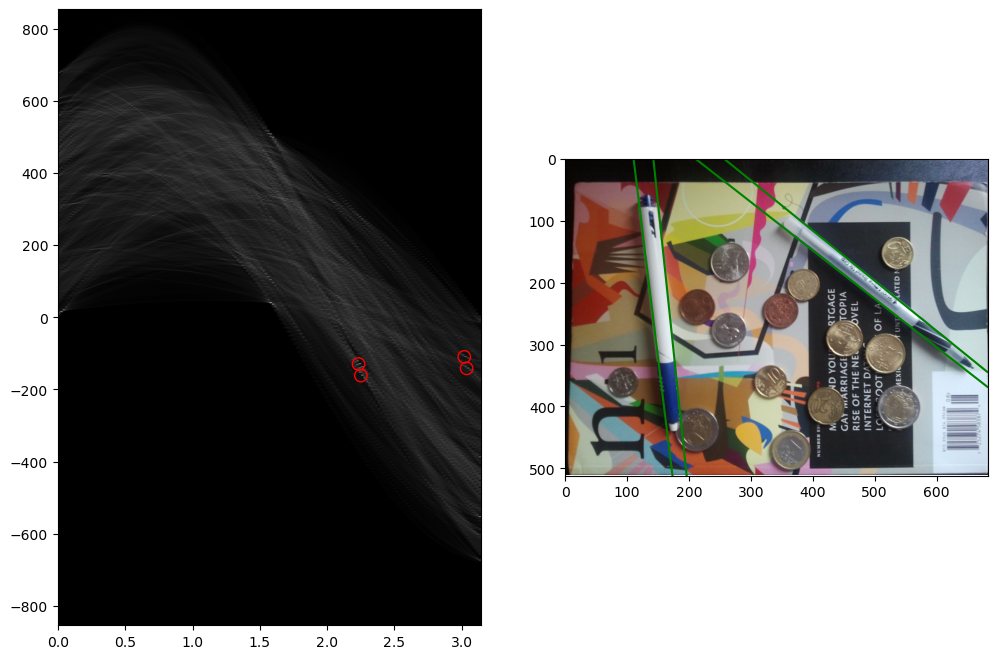

In [28]:
# Select the parallel lines 
def filter_parallel(lines, dist_min=25, dist_max=50, theta_thresh=2*np.pi/180):
    parallel_lines = []
    for i, (rho1, theta1) in enumerate(lines):
        for (rho2, theta2) in lines[i+1:]:
            if abs(theta1 - theta2) < theta_thresh and dist_min < abs(rho1 - rho2) and abs(rho1 - rho2) < dist_max:
                parallel_lines.append((rho1, theta1))
                parallel_lines.append((rho2, theta2))
    return parallel_lines

img2_parallel_lines = filter_parallel(detected_lines)
# Plot
fig, ax = plt.subplots(1, 2)

ax[0].imshow(hough_acc_img2, aspect='auto', origin='lower', extent=[0, np.pi, rho_min, rho_max])
for rho, theta in img2_parallel_lines:
    ax[0].scatter(theta, rho, s=80, facecolors='none', edgecolors='r')

x_range = range(img2.shape[1])
y_range = range(img2.shape[0])
ax[1].set_ylim(img2.shape[0], 0)
ax[1].set_xlim(0, img2.shape[1])
ax[1].imshow(img2)
for rho, theta in img2_parallel_lines:
    # transfer (rho, theta) to the lines   
    if np.sin(theta):
        fx = (rho - x_range*np.cos(theta)) / np.sin(theta)
        plt.plot(x_range, fx,  'g')
    else:
        # Vertical line
        fy = (rho - y_range*np.sin(theta)) / np.cos(theta)
        plt.plot(y_range, fy, 'g')

---
## 7. Clutter Image: Circles
### a. Hough circle detector

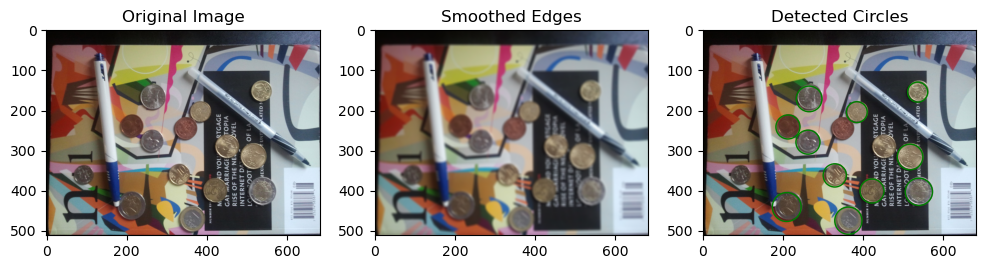

In [40]:
r_min = 1.0
r_max = 50.0

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img2)
ax[0].set_title('Original Image')

ax[1].imshow(img2_smooth)
ax[1].set_title('Smoothed Edges')

# r_min = 1.0
# r_max = 300.0

clutter_r_res = 1
clutter_ab_res = 1
clutter_threshold = 80

image2_circles_acc = accumulate_circle(img2_edges_smooth, r_min, r_max, r_res = clutter_r_res, ab_res = clutter_ab_res)
image2_circles = extract_circle(img2_edges_smooth, image2_circles_acc, r_min, r_max, r_res = clutter_r_res, ab_res = clutter_ab_res, threshold = clutter_threshold)

ax[2].set_title('Detected Circles')
ax[2].imshow(img2)
for x,y,r in image2_circles:
    circ = plt.Circle((x, y), r,color = 'g', fill = False)
    ax[2].add_patch(circ)

### b. False Alarms


Yes, there are some falses alarm.<br> Some repeated circles occured in the result.
To solve this problem, I use a filter that can remove some close circles. By only reserving the circle that have biggest accmulation, the other circles that close to it are abandoned.


---
## 8. Sensitivity to distortion

In [26]:
img3 = cv.imread('ps1-input3.jpg')
img3 = img3[:,:,::-1]

### a. Line and Circle Detection

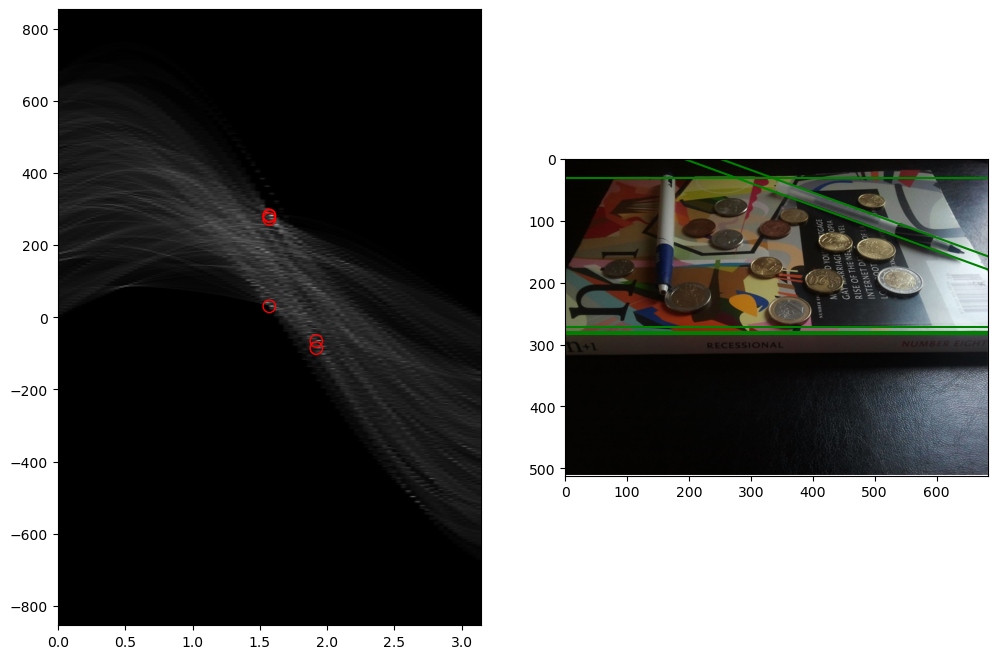

In [42]:
# Smooth and Edge Detection
img3_smooth = cv.GaussianBlur(img3, (13, 13), 3)
img3_edges_smooth = cv.Canny(img3_smooth, 40, 70)

#line detecter
rho_max = np.sqrt(img3_edges_smooth.shape[0]**2 + img3_edges_smooth.shape[1]**2)
rho_min = -rho_max
hough_acc_img3 = accumulate(img3_edges_smooth, rho_res = 1.0, theta_res = 2.0 * np.pi/180)
detected_lines_3 = extract_lines(img3_edges_smooth, hough_acc_img3, rho_res = 1.0, theta_res =2.0 * np.pi/180, thresh = 100)
img3_parallel_lines = filter_parallel(detected_lines_3)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(hough_acc_img3, aspect='auto', origin='lower', extent=[0, np.pi, rho_min, rho_max])
for rho, theta in detected_lines_3:
    ax[0].scatter(theta, rho, s=80, facecolors='none', edgecolors='r')

x_range = range(img3.shape[1])
y_range = range(img3.shape[0])
ax[1].set_ylim(img3.shape[0], 0)
ax[1].set_xlim(0, img3.shape[1])
ax[1].imshow(img3)
for rho, theta in detected_lines_3:
    # transfer (rho, theta) to the lines   
    if np.sin(theta):
        fx = (rho - x_range*np.cos(theta)) / np.sin(theta)
        plt.plot(x_range, fx,  'g')
    else:
        # Vertical line
        fy = (rho - y_range*np.sin(theta)) / np.cos(theta)
        plt.plot(y_range, fy, 'g')




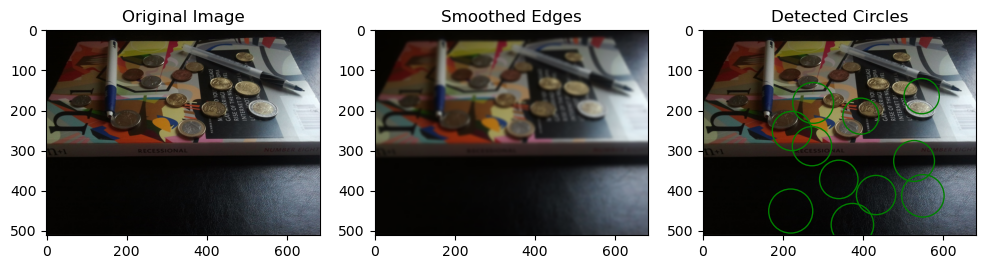

In [43]:
#circle detecter
r_min = 20.0
r_max = 40.0

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img3)
ax[0].set_title('Original Image')

ax[1].imshow(img3_smooth)
ax[1].set_title('Smoothed Edges')

image3_circles_acc = accumulate_circle(img3_edges_smooth, r_min, r_max, 1, 1)
image3_circles = extract_circle(img3_edges_smooth, image2_circles_acc, r_min, r_max, 1, 1, threshold = 80)

ax[2].set_title('Detected Circles')
ax[2].imshow(img3)
for x,y,r in image3_circles:
    circ = plt.Circle((x, y), r,color = 'g', fill = False)
    ax[2].add_patch(circ)

### b. Fix the Problems


Because of the distortion, the circle detection method can't work well for the new picture. <br>
There are two solutions to deal with these problem.<br>
Firstly, some algorithms can help transform the ellipses to circle, so we can restore the image and try to convert the ellipse into a circle. After the circle detection for restored picture, we turn the detected circle into an ellipse and display it on the picture.<br>
Another solution is more direct, we can just extend the existed circle transform method to ellipses by adding more parameters.<br>
Considering the complexity of algorithm, I choose the first solution to try to dix the problem.

### c. Fixing the Circle Problems

I draw a "Viewfinder" in the original Image, which indicates that I would apply transform method in this Viewfinder. In the drawing software, I can read the four vertex coordinates of the viewfinder frame.

Text(0.5, 1.0, 'fixed Edges')

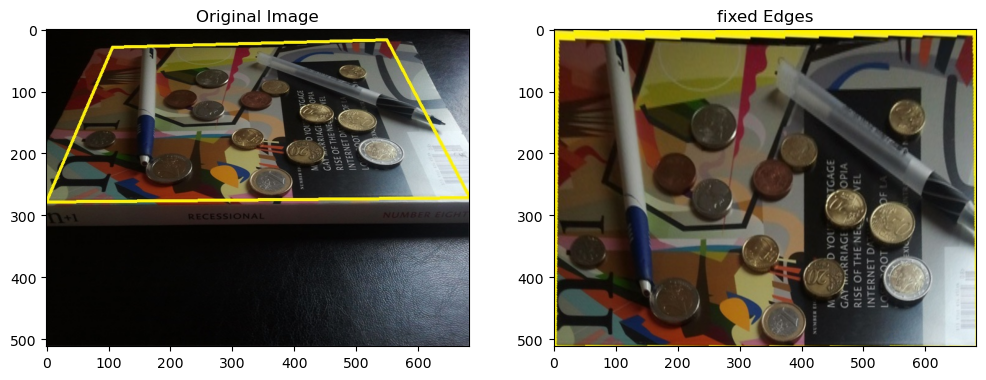

In [47]:
img3_vf = cv.imread('ps1-input3_viewfinder.jpg')
img3_vf = img3_vf[:,:,::-1]

#set transform matrix
pts1 = np.array([[0,0],[img3.shape[1]-1, 0],[img3.shape[1]-1, img3.shape[0]-1],[0, img3.shape[0]-1]], dtype = "float32")
pts2 = np.array([[106,26],[551,16],[681,269],[0,277]], dtype = "float32")

img3_fixed = cv.warpPerspective(img3_vf, cv.getPerspectiveTransform(pts2, pts1), (img3.shape[1], img3.shape[0]))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img3_vf)
ax[0].set_title('Original Image')

ax[1].imshow(img3_fixed)
ax[1].set_title('fixed Edges')

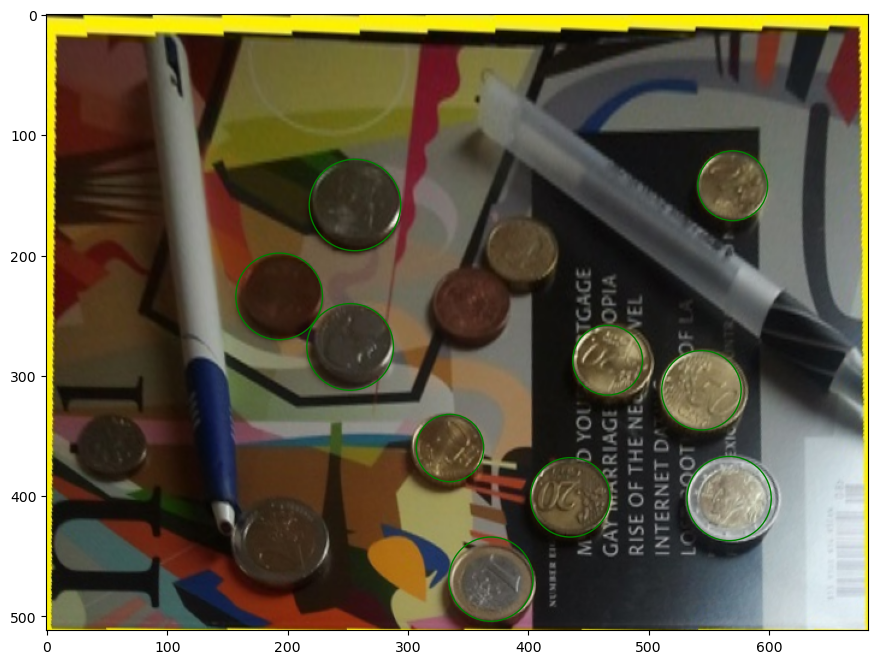

In [61]:
r_min = 1.0
r_max = 40.0
img3_fixed_smooth = cv.GaussianBlur(img3_fixed, (5, 5), 3)
img3_fixed_edges_smooth = cv.Canny(img3_fixed_smooth, 50, 100)


image3_circles_acc_fixed = accumulate_circle(img3_fixed_edges_smooth, r_min, r_max, 1, 1)
image3_circles_fixed = extract_circle(img3_fixed_edges_smooth, image3_circles_acc_fixed, r_min, r_max, 1, 1, threshold = 80)

plt.imshow(img3_fixed)
for x,y,r in image3_circles_fixed:
    circ = plt.Circle((x, y), r,color = 'g', fill = False)
    plt.gca().add_patch(circ)

plt.savefig("./img3_fixed_circle.jpg")

In [68]:
# img3_vff = cv.imread('img3_fixed_circle.jpg')
# img3_vff = img3_vff[:,:,::-1]

# img3_circles = cv.warpPerspective(img3_vff, cv.getPerspectiveTransform(pts1, pts2), (img3.shape[1], img3.shape[0]))
# plt.imshow(img3_circles)